# Classificazione dei coralli usando metodi supervisionati e non supervisionati

L'obiettivo di questo progetto è di classificare immagini di coralli in base alle loro caratteristiche utilizzando sia metodi supervisionati che non supervisionati per poi confrontare le prestazioni dei due approcci.

## Introduzione

I coralli sono organismi che vivono in mare e sono molto importanti per la biodiversità e la salute del mare. Avere un sistema per classificare i coralli in base alle loro caratteristiche è molto utile per velocizzare il processo degli specialisti degli oceani, soprattutto se utilizzassimo un modello non supervisionato che eviterebbe il processo di etichettare ogni immagine dei coralli.

# Imports

In [5]:
import os
import skimage
import cv2
import imageio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import pandas as pd
from pyclustering.cluster.kmedians import kmedians
import seaborn as sns
from skimage import io
from skimage.color import rgb2gray
import skfuzzy.cluster as fkc
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    adjusted_rand_score,
    classification_report,
    completeness_score,
    confusion_matrix,
    homogeneity_score,
    normalized_mutual_info_score,
    silhouette_score,
    v_measure_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Estrazione delle feature

In questa sezione trasformiamo le immagini da RGB a livelli di grigio per poi utilizzare l'algoritmo `Gray-Level Co-occurence Matrix` (GLCM) per estrarre le texture feature e memorizzarle in un dataframe.

In [6]:
train_folder = "REEF_DATASET/EILAT/"
features_list = []         # Lista per le feature
ground_truth_labels_list = [] # lista per le etichette di ground truth

# Loop attraverso i numeri delle directory (gli interi da 1 a 8)
for directory_label in range(1, 9): 
    sub_folder_name = f"A0{directory_label}"

    for i in range(1, 300):
        image_filename = f"{sub_folder_name}/T{i}.jpg" 
        image_path = os.path.join(train_folder, image_filename)

        if not os.path.exists(image_path):
            continue

        image = cv2.imread(image_path)

        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        distances = [5]
        angles = [0]
        
        glcm = skimage.feature.graycomatrix(image_gray,
                                            distances=distances,
                                            angles=angles,
                                            levels=256,
                                            symmetric=True,
                                            normed=True)

        contrast = skimage.feature.graycoprops(glcm, 'contrast')[0, 0]
        correlation = skimage.feature.graycoprops(glcm, 'correlation')[0, 0]
        energy = skimage.feature.graycoprops(glcm, 'energy')[0, 0]
        homogeneity = skimage.feature.graycoprops(glcm, 'homogeneity')[0, 0]
        asm = skimage.feature.graycoprops(glcm, 'ASM')[0, 0]
        dissimilarity = skimage.feature.graycoprops(glcm, 'dissimilarity')[0, 0]
        entropy = skimage.feature.graycoprops(glcm, 'entropy')[0, 0]
        mean = skimage.feature.graycoprops(glcm, 'mean')[0, 0]
        std = skimage.feature.graycoprops(glcm, 'std')[0, 0]
        variance = skimage.feature.graycoprops(glcm, 'variance')[0, 0]
        

        
        current_features = {
            'contrast': contrast,
            'correlation': correlation,
            'energy': energy,
            'homogeneity': homogeneity,
            'ASM': asm,
            'dissimilarity': dissimilarity,
            'entropy': entropy,
            'mean': mean,
            'std': std,
            'variance': variance
        }
        features_list.append(current_features)
        ground_truth_labels_list.append(directory_label)

df = pd.DataFrame(features_list)
true_labels = np.array(ground_truth_labels_list) - 1
print(f"DataFrame creato con {len(df)} campioni.")
print(f"Array di ground truth 'true_labels' creato con {len(true_labels)} etichette.")
df

DataFrame creato con 1054 campioni.
Array di ground truth 'true_labels' creato con 1054 etichette.


,contrast,correlation,energy,homogeneity,ASM,dissimilarity,entropy,mean,std,variance
0,544.768538,0.164024,0.020326,0.057026,0.000413,17.843220,7.997028,143.234375,18.050699,325.827748
1,197.159163,0.177359,0.032063,0.100065,0.001028,10.411811,7.188701,152.632813,10.946826,119.832996
2,102.146186,0.431943,0.035535,0.116129,0.001263,7.942267,6.980690,137.713189,9.482008,89.908470
3,815.514301,0.497055,0.016059,0.046025,0.000258,22.314089,8.414303,157.313030,28.473477,810.738877
4,387.655191,0.082963,0.024333,0.073753,0.000592,14.957627,7.685513,137.418432,14.538321,211.362785
...,...,...,...,...,...,...,...,...,...,...
1049,491.407839,0.618481,0.017489,0.057255,0.000306,17.510064,8.268916,105.647511,25.377462,644.015582
1050,633.080773,0.529442,0.016660,0.048319,0.000278,19.966367,8.334621,114.436573,25.936290,672.691157
1051,454.685911,0.701969,0.016817,0.055190,0.000283,16.983581,8.321434,89.413930,27.619118,762.815685
1052,412.023305,0.559700,0.018616,0.061413,0.000347,16.173729,8.152220,115.971928,21.630755,467.889572


In [7]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df)
features_scaled

array([[-0.81397624, -1.21606367,  0.46831793, ...,  0.75474014,
        -1.1857999 , -1.04119277],
       [-1.28758629, -1.14645069,  2.72968804, ...,  1.04575276,
        -1.87000868, -1.34591884],
       [-1.41703936,  0.18257394,  3.39853569, ...,  0.58378247,
        -2.01109248, -1.3901859 ],
       ...,
       [-0.93671182,  1.59220285, -0.20761512, ..., -0.9117527 ,
        -0.26421872, -0.3947607 ],
       [-0.99483867,  0.84951044,  0.13902647, ..., -0.08941254,
        -0.84098722, -0.83104208],
       [-0.4972467 , -0.62783137, -0.16848063, ...,  0.08956081,
        -0.69182546, -0.72838371]], shape=(1054, 10))

## Clustering Fuzzy K-Means (Fuzzy C-Means)

Per il raggruppamento non supervisionato delle immagini in base alle feature estratte, utilizzeremo l'algoritmo Fuzzy C-Means (spesso indicato anche come Fuzzy K-Means). Questo approccio permette a ciascun dato (nel nostro caso, un'immagine rappresentata dalle sue feature) di appartenere a più cluster contemporaneamente, con un diverso grado di appartenenza (membership).

Prima di applicare l'algoritmo, è fondamentale determinare un numero ottimale di cluster (K). Per fare ciò, valuteremo i risultati ottenuti con diversi valori di K utilizzando i seguenti indici e metodi:

1.  **Metodo dell'Elbow (per Fuzzy C-Means):**
    Questo metodo si basa sulla visualizzazione del valore della **funzione obiettivo** dell'algoritmo Fuzzy C-Means al variare del numero di cluster K. Si cerca un "gomito" (elbow) nel grafico, ovvero un punto in cui l'aggiunta di ulteriori cluster non porta a una diminuzione significativa del valore della funzione obiettivo. Questo punto suggerisce un buon compromesso tra il numero di cluster e la compattezza dei cluster stessi.

2.  **Coefficiente di Silhouette (Silhouette Score):**
    Questo coefficiente misura quanto un campione sia simile al proprio cluster (coesione) rispetto agli altri cluster (separazione). Il valore varia da -1 a +1:
    *   Un valore vicino a +1 indica che il campione è ben distante dai cluster vicini.
    *   Un valore vicino a 0 indica che il campione è vicino al confine decisionale tra due cluster.
    *   Un valore vicino a -1 indica che il campione potrebbe essere stato assegnato al cluster sbagliato.
    Si cerca il valore di K che massimizza il coefficiente di Silhouette medio per l'intero dataset. Per utilizzare questo metodo con Fuzzy C-Means, le appartenenze fuzzy vengono prima convertite in assegnazioni "nette" (crisp) al cluster con grado di appartenenza maggiore.

3.  **Coefficiente di Partizione Fuzzy (FPC - Fuzzy Partition Coefficient):**
    Specifico per algoritmi di clustering fuzzy, l'FPC misura il grado di "nettezza" (crispness) della partizione fuzzy. Il suo valore varia da `1/K` (partizione molto fuzzy, con appartenenze distribuite) a 1 (partizione il più netta possibile per un algoritmo fuzzy, dove ogni punto tende ad appartenere prevalentemente a un solo cluster). Generalmente, si preferiscono valori di FPC più alti, ma questo va interpretato insieme agli altri indici, poiché un FPC molto alto potrebbe indicare che un clustering "hard" (come K-Means standard) sarebbe stato sufficiente.

Una volta identificato il valore ottimale (o un range di valori plausibili) per K, applicheremo l'algoritmo Fuzzy C-Means per raggruppare le immagini, analizzando le loro feature e i gradi di appartenenza ai diversi cluster.

In [8]:
# Data per silhouette score (samples x features)
data_for_silhouette = features_scaled
# Data per fkc.cmeans (features x samples)
data_to_cluster_transposed = data_for_silhouette.T 

min_k = 2
max_k = 13 
possible_n_clusters = range(min_k, max_k + 1) 

objective_function_values = [] 
fpc_values = []
silhouette_scores = []

for k_clusters in possible_n_clusters:
    m_fuzziness = 2.0         
    error_tolerance = 0.005   
    max_iterations = 1000     

    cntr, u, u0, d, jm_history_for_k, p_iterations, fpc_val = fkc.cmeans(
        data_to_cluster_transposed,
        c=k_clusters,
        m=m_fuzziness,
        error=error_tolerance,
        maxiter=max_iterations,
        init=None 
    )
    
    objective_function_values.append(jm_history_for_k[-1])
    fpc_values.append(fpc_val)
    
    crisp_labels = np.argmax(u, axis=0)
    
    if k_clusters > 1 and len(np.unique(crisp_labels)) > 1: # Mi assicuro che almeno un cluster sia stato creato
        score = silhouette_score(data_for_silhouette, crisp_labels, random_state=42)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(np.nan) # Altrimenti aggiungo un valore nullo


### Visualizzazione metodo elbow

Adesso visualizziamo il metodo elbow per trovare il numero ottimale di cluster. 
Scegliamo come k il punto in cui la variazione inizia a diminuire drasticamente, cioè il "gomito".

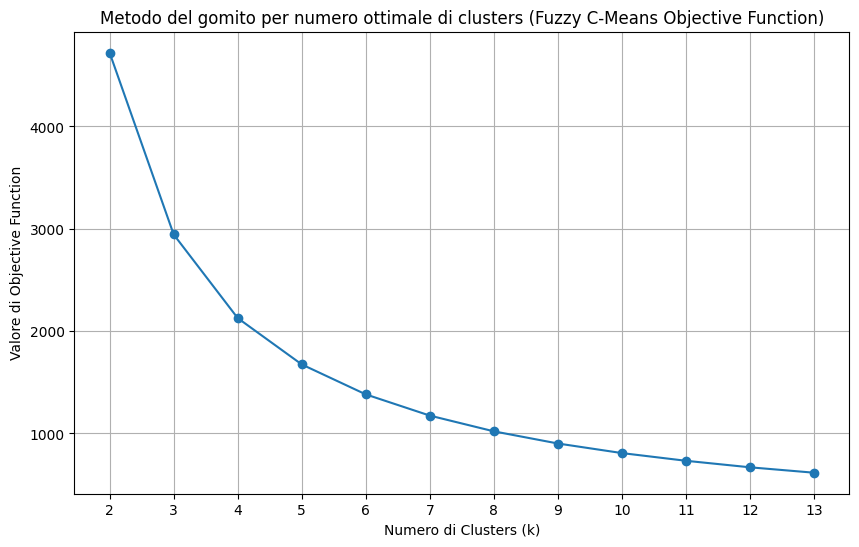

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(list(possible_n_clusters), objective_function_values, marker='o', linestyle='-')
plt.title('Metodo del gomito per numero ottimale di clusters (Fuzzy C-Means Objective Function)')
plt.xlabel('Numero di Clusters (k)')
plt.ylabel('Valore di Objective Function')
plt.xticks(list(possible_n_clusters))
plt.grid(True)
plt.show()

### Visualizzazione silhouette score

Adesso visualizziamo il silhouette score per trovare il numero ottimale di cluster. 
Questo indice è solitamente il più "robusto" e più affidabile.
Più il silhouette score è alto, più i cluster sono ben definiti.

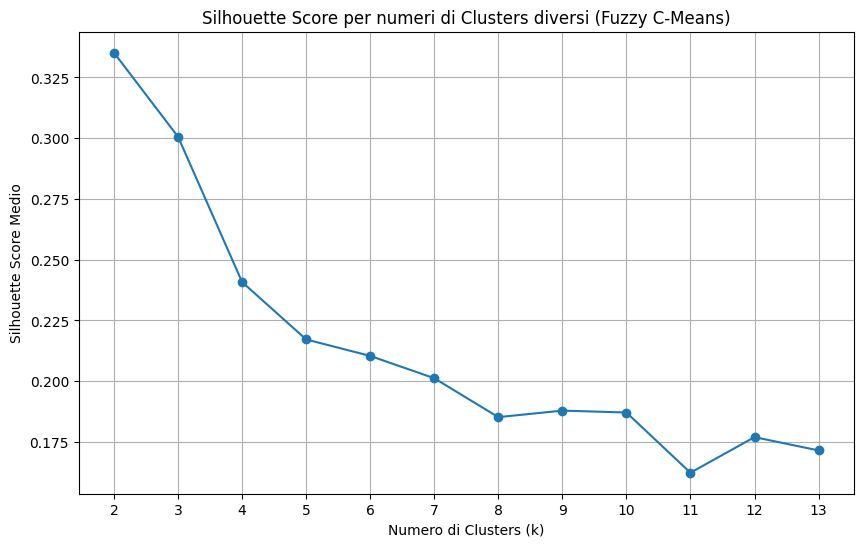

In [10]:
plt.figure(figsize=(10, 6))
# Filtro i valori nulli
valid_indices = [i for i, score in enumerate(silhouette_scores) if not np.isnan(score)]
valid_k = [list(possible_n_clusters)[i] for i in valid_indices]
valid_scores = [silhouette_scores[i] for i in valid_indices]

plt.plot(valid_k, valid_scores, marker='o', linestyle='-')
plt.title('Silhouette Score per numeri di Clusters diversi (Fuzzy C-Means)')
plt.xlabel('Numero di Clusters (k)')
plt.ylabel('Silhouette Score Medio')
plt.xticks(valid_k)
plt.grid(True)
plt.show()


### Visualizzazione del coefficiente di partizione

Visualizziamo il coefficiente di partizione per trovare il numero ottimale di cluster.

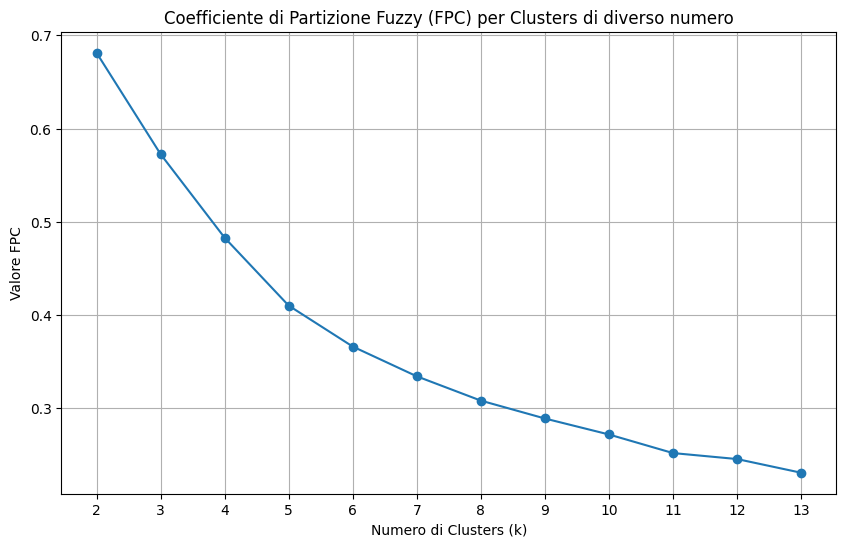

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(list(possible_n_clusters), fpc_values, marker='o', linestyle='-')
plt.title('Coefficiente di Partizione Fuzzy (FPC) per Clusters di diverso numero')
plt.xlabel('Numero di Clusters (k)')
plt.ylabel('Valore FPC')
plt.xticks(list(possible_n_clusters))
plt.grid(True)
plt.show()

### Scelta del miglior numero di cluster

Ora che abbiamo calcoalto e visualizzato i tre valori importanti per la scelta del numero di cluster, possiamo utilizzare l'algoritmo Fuzzy K-means.

In [12]:
# Create a dictionary from your metrics
metrics_data = {
    'Numero di Clusters (k)': list(possible_n_clusters),
    'Objective Function': objective_function_values,
    'Silhouette Score': silhouette_scores,
    'FPC': fpc_values
}

# Create a pandas DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Set 'Number of Clusters (k)' as the index for better readability (optional)
metrics_df = metrics_df.set_index('Numero di Clusters (k)')

def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

styled_df = metrics_df.style.apply(highlight_max, props='color:green; font-weight:bold;', subset=['Silhouette Score', 'FPC'], axis=0)\
                            .apply(highlight_min, props='color:red; font-weight:bold;', subset=['Objective Function'], axis=0)\
                            .format("{:.4f}", subset=['Objective Function', 'Silhouette Score', 'FPC']) # Format floats

display(styled_df)


,Objective Function,Silhouette Score,FPC
Numero di Clusters (k),,,
2,4720.9222,0.3352,0.6814
3,2944.2816,0.3006,0.5726
4,2126.9186,0.2408,0.4830
5,1674.0617,0.2172,0.4102
6,1381.2454,0.2104,0.3662
7,1173.9078,0.2012,0.3343
8,1020.0445,0.1852,0.3083
9,901.1326,0.1879,0.2891
10,807.4988,0.1871,0.2719


Visualizziamo per k = 8


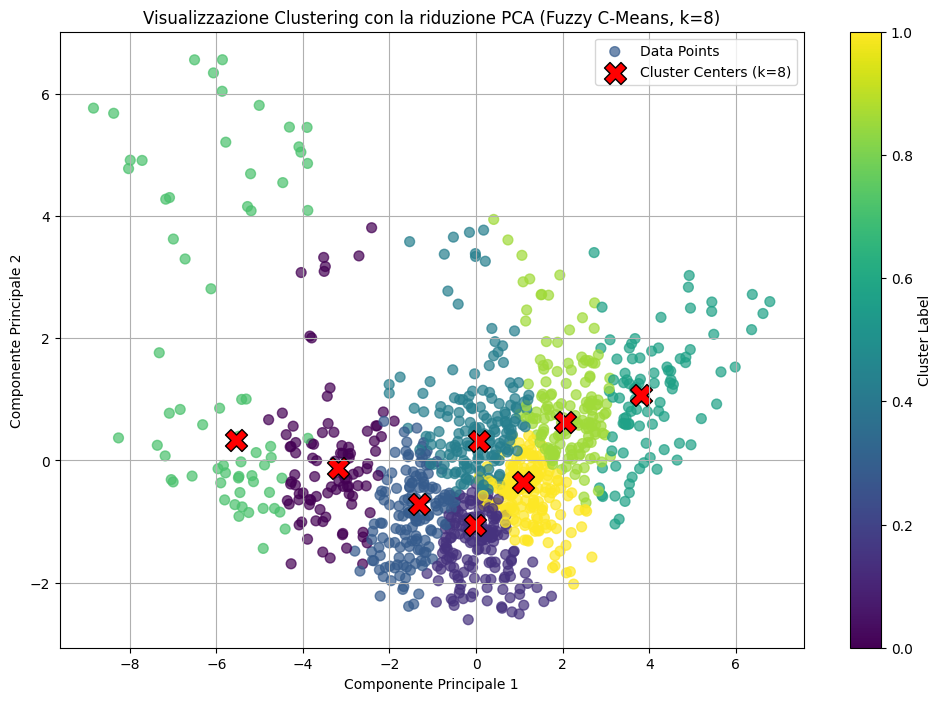


Fuzzy Memberships per i primi 5 punti (k=8):


,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8
Data Point Index,,,,,,,,
0,0.167,0.189,0.394,0.080,0.019,0.041,0.037,0.072
1,0.104,0.034,0.049,0.029,0.014,0.725,0.020,0.025
2,0.114,0.042,0.058,0.040,0.021,0.663,0.028,0.034
3,0.045,0.254,0.143,0.174,0.029,0.016,0.090,0.251
4,0.362,0.106,0.191,0.070,0.023,0.150,0.038,0.059


In [13]:
original_data = features_scaled
# Dati trasposti per cmeans (features x samples)
data_to_cluster_transposed = original_data.T

chosen_k = 8 
print(f"Visualizziamo per k = {chosen_k}")

m_fuzziness = 2.0         
error_tolerance = 0.005   
max_iterations = 1000     

cntr_chosen_k, u_chosen_k, u0_chosen_k, d_chosen_k, jm_chosen_k, p_chosen_k, fpc_chosen_k = fkc.cmeans(
    data_to_cluster_transposed,
    c=chosen_k,
    m=m_fuzziness,
    error=error_tolerance,
    maxiter=max_iterations,
    init=None 
)

crisp_labels_for_chosen_k = np.argmax(u_chosen_k, axis=0)

# PCA 
pca = PCA(n_components=2, random_state=42) 
X_pca = pca.fit_transform(original_data) # Usiamo i dati originali

pca_transformed_centers = pca.transform(cntr_chosen_k)

plt.figure(figsize=(12, 8))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=crisp_labels_for_chosen_k, cmap='viridis', s=50, alpha=0.7, label='Data Points')

plt.scatter(pca_transformed_centers[:, 0], pca_transformed_centers[:, 1], 
            c='red', s=250, marker='X', edgecolors='black', label=f'Cluster Centers (k={chosen_k})')

plt.title(f'Visualizzazione Clustering con la riduzione PCA (Fuzzy C-Means, k={chosen_k})')
plt.xlabel('Componente Principale 1')
plt.ylabel('Componente Principale 2')
plt.legend()
plt.grid(True)
plt.colorbar(label='Cluster Label') 
plt.show()

# Mostro la membership per alcuni punti per vedere quanto sono "fuzzy"
num_points_to_show = 5
print(f"\nFuzzy Memberships per i primi {num_points_to_show} punti (k={chosen_k}):")
membership_df = pd.DataFrame(u_chosen_k[:, :num_points_to_show].T, 
                             columns=[f'Cluster {i+1}' for i in range(chosen_k)])
membership_df.index.name = 'Data Point Index'
display(membership_df.style.format("{:.3f}").background_gradient(cmap='viridis', axis=1))

L'analisi delle componenti principali, o PCA, riduce il numero di dimensioni in grandi set di dati a componenti principali che conservano la maggior parte delle informazioni originali. Ciò avviene trasformando le variabili potenzialmente correlate in un insieme più piccolo di variabili, denominate componenti principali.

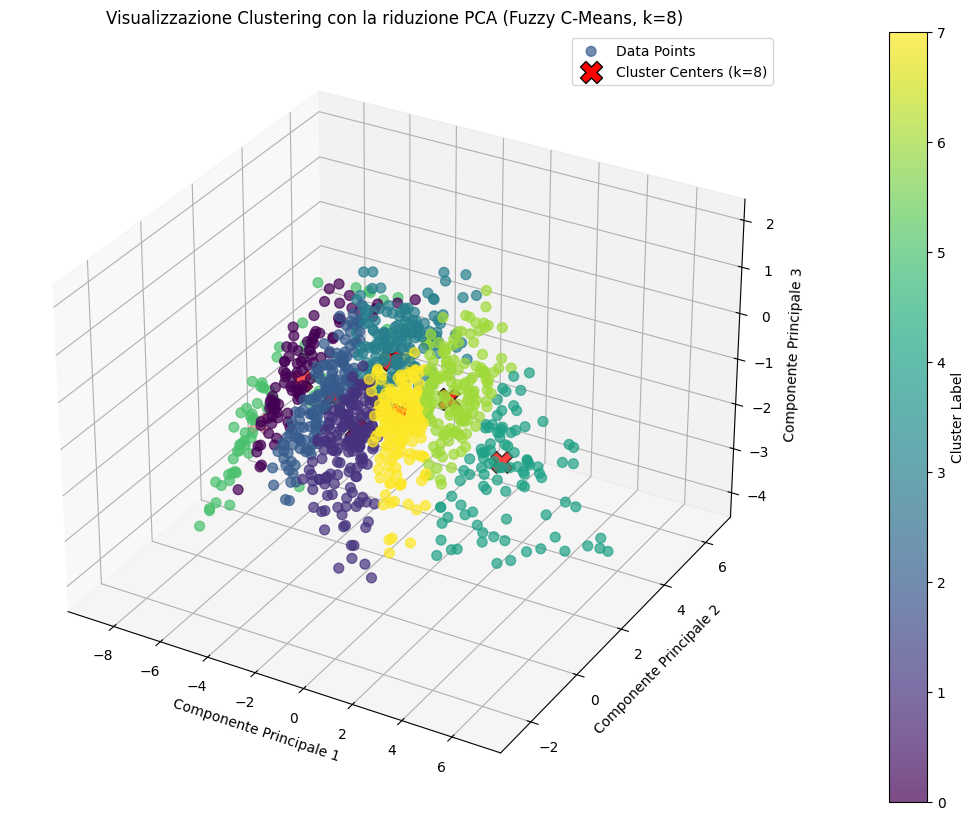

In [14]:
pca_3d = PCA(n_components=3, random_state=42) 
X_pca_3d = pca_3d.fit_transform(original_data)

pca_transformed_centers_3d = pca_3d.transform(cntr_chosen_k)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d') 

scatter_data = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], 
                          c=crisp_labels_for_chosen_k, cmap='viridis', s=50, alpha=0.7, label='Data Points')

ax.scatter(pca_transformed_centers_3d[:, 0], pca_transformed_centers_3d[:, 1], pca_transformed_centers_3d[:, 2],
           c='red', s=250, marker='X', edgecolors='black', depthshade=True, label=f'Cluster Centers (k={chosen_k})')

ax.set_title(f'Visualizzazione Clustering con la riduzione PCA (Fuzzy C-Means, k={chosen_k})')
ax.set_xlabel('Componente Principale 1')
ax.set_ylabel('Componente Principale 2')
ax.set_zlabel('Componente Principale 3')

cbar = fig.colorbar(scatter_data, ax=ax, pad=0.1) 
cbar.set_label('Cluster Label')

ax.legend()
plt.show()


--- Valutazione Performance Clustering (Fuzzy C-Means, k=8) ---
  Adjusted Rand Index (ARI):      0.1108
  Normalized Mutual Info (NMI):   0.2403
  Homogeneity:                    0.2506
  Completeness:                   0.2308
  V-measure:                      0.2403
  Fuzzy Partition Coefficient (FPC): 0.3083


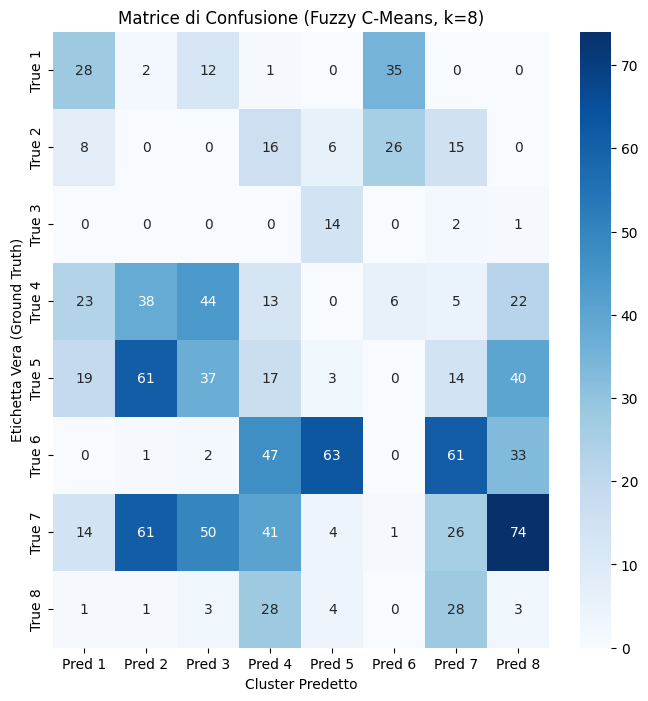

In [15]:

predicted_labels = crisp_labels_for_chosen_k # Etichette rese "crisp" da Fuzzy C-Means

# Calcolo delle metriche
ari = adjusted_rand_score(true_labels, predicted_labels)
nmi = normalized_mutual_info_score(true_labels, predicted_labels)
homogeneity = homogeneity_score(true_labels, predicted_labels)
completeness = completeness_score(true_labels, predicted_labels)
v_measure = v_measure_score(true_labels, predicted_labels)

print(f"\n--- Valutazione Performance Clustering (Fuzzy C-Means, k={chosen_k}) ---")
print(f"  Adjusted Rand Index (ARI):      {ari:.4f}")
print(f"  Normalized Mutual Info (NMI):   {nmi:.4f}")
print(f"  Homogeneity:                    {homogeneity:.4f}")
print(f"  Completeness:                   {completeness:.4f}")
print(f"  V-measure:                      {v_measure:.4f}")

if 'fpc_chosen_k' in locals():
        print(f"  Fuzzy Partition Coefficient (FPC): {fpc_chosen_k:.4f}")


# Matrice di Confusione
expected_labels_indices = range(chosen_k) # Da 0 a chosen_k-1

cm = confusion_matrix(true_labels, predicted_labels, labels=expected_labels_indices)

plt.figure(figsize=(max(8, chosen_k), max(6, chosen_k))) 

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f'Pred {i+1}' for i in expected_labels_indices],
            yticklabels=[f'True {i+1}' for i in expected_labels_indices])
plt.xlabel("Cluster Predetto")
plt.ylabel("Etichetta Vera (Ground Truth)")
plt.title(f"Matrice di Confusione (Fuzzy C-Means, k={chosen_k})") 
plt.show()

### K-means

Adesso proviamo utilizzando l'algoritmo K-means (hard clustering) per vedere se otteniamo risultati migliori.

In [16]:
# Dati per K-Means e silhouette score (samples x features)
data_for_kmeans = features_scaled

min_k = 2
max_k = 13 
possible_n_clusters = range(min_k, max_k + 1) 

inertia_values = []    
silhouette_scores = [] 

MAX_ITERATIONS_KMEANS = 300 

for k_clusters in possible_n_clusters:
    kmeans = KMeans(
        n_clusters=k_clusters,
        max_iter=MAX_ITERATIONS_KMEANS,
        random_state=42,                
        n_init='auto'                   
    )
    
    kmeans.fit(data_for_kmeans)
    
    inertia_values.append(kmeans.inertia_)
    
    crisp_labels = kmeans.labels_
    
    if k_clusters > 1 and len(np.unique(crisp_labels)) > 1:
        score = silhouette_score(data_for_kmeans, crisp_labels, random_state=42)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(np.nan)


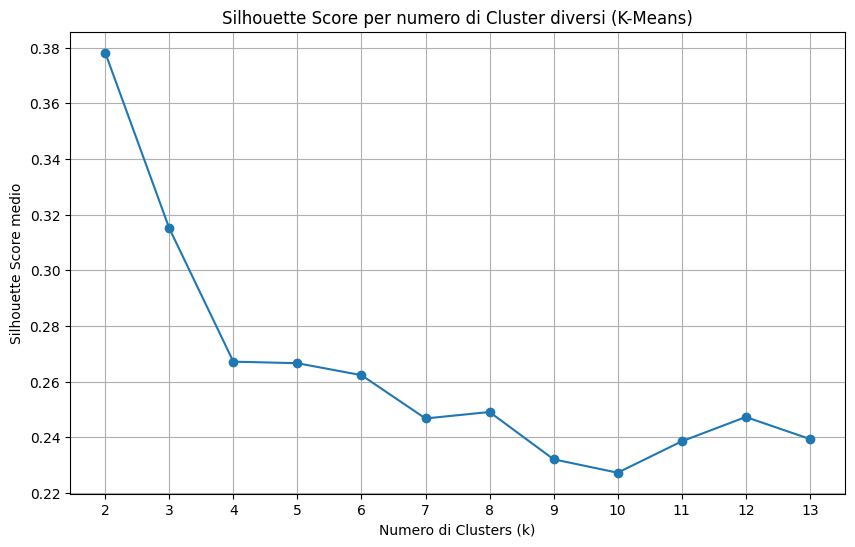

In [17]:
plt.figure(figsize=(10, 6))
# Filtriamo i valori nulli
valid_indices = [i for i, score in enumerate(silhouette_scores) if not np.isnan(score)]
valid_k = [list(possible_n_clusters)[i] for i in valid_indices]
valid_scores = [silhouette_scores[i] for i in valid_indices]

plt.plot(valid_k, valid_scores, marker='o', linestyle='-')
plt.title('Silhouette Score per numero di Cluster diversi (K-Means)')
plt.xlabel('Numero di Clusters (k)')
plt.ylabel('Silhouette Score medio')
plt.xticks(valid_k)
plt.grid(True)
plt.show()

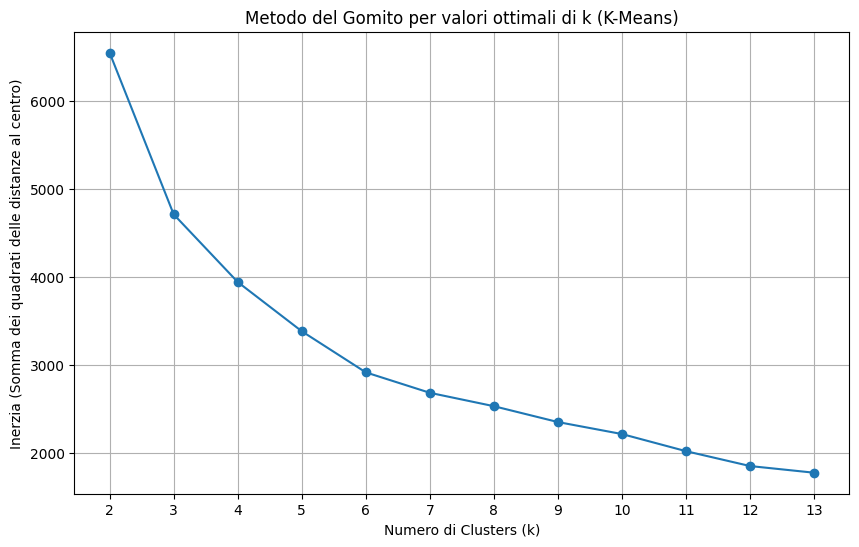

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(possible_n_clusters, inertia_values, marker='o', linestyle='-')
plt.title('Metodo del Gomito per valori ottimali di k (K-Means)')
plt.xlabel('Numero di Clusters (k)')
plt.ylabel('Inerzia (Somma dei quadrati delle distanze al centro)')
plt.xticks(list(possible_n_clusters)) 
plt.grid(True)
plt.show()

In [19]:
metrics_data = {
    'Numero di Cluster (k)': list(possible_n_clusters),
    'Inerzia': inertia_values,
    'Silhouette Score': silhouette_scores,
}

metrics_df = pd.DataFrame(metrics_data)

metrics_df = metrics_df.set_index('Numero di Cluster (k)')

def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

styled_df = metrics_df.style.apply(highlight_max, props='color:green; font-weight:bold;', subset=['Silhouette Score'], axis=0)\
                            .apply(highlight_min, props='color:red; font-weight:bold;', subset=['Inerzia'], axis=0)\
                            .format("{:.4f}", subset=['Inerzia', 'Silhouette Score']) # Format floats

display(styled_df)


,Inerzia,Silhouette Score
Numero di Cluster (k),,
2,6544.9172,0.3782
3,4709.7984,0.3151
4,3941.2721,0.2672
5,3382.5218,0.2666
6,2915.7110,0.2623
7,2683.6014,0.2467
8,2531.6315,0.2491
9,2351.5259,0.2321
10,2215.2836,0.2272


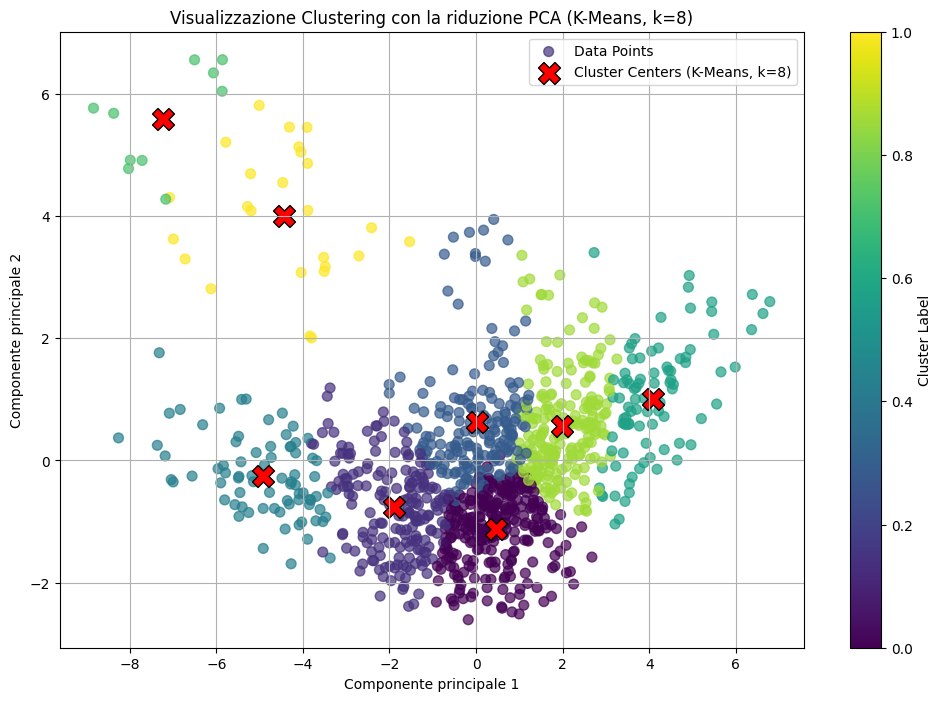

In [20]:
original_data = features_scaled # (samples x features)

chosen_k = 8

kmeans = KMeans(
    n_clusters=chosen_k,
    max_iter=MAX_ITERATIONS_KMEANS, 
    random_state=42,               
    n_init='auto'                   
)

crisp_labels_for_chosen_k = kmeans.fit_predict(original_data)

cluster_centers_original_space = kmeans.cluster_centers_

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(original_data) 

pca_transformed_centers = pca.transform(cluster_centers_original_space)

plt.figure(figsize=(12, 8))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=crisp_labels_for_chosen_k, cmap='viridis', s=50, alpha=0.7, label='Data Points')

plt.scatter(pca_transformed_centers[:, 0], pca_transformed_centers[:, 1],
            c='red', s=250, marker='X', edgecolors='black', label=f'Cluster Centers (K-Means, k={chosen_k})')

plt.title(f'Visualizzazione Clustering con la riduzione PCA (K-Means, k={chosen_k})')
plt.xlabel('Componente principale 1')
plt.ylabel('Componente principale 2')
plt.legend()
plt.grid(True)
plt.colorbar(label='Cluster Label')
plt.show()

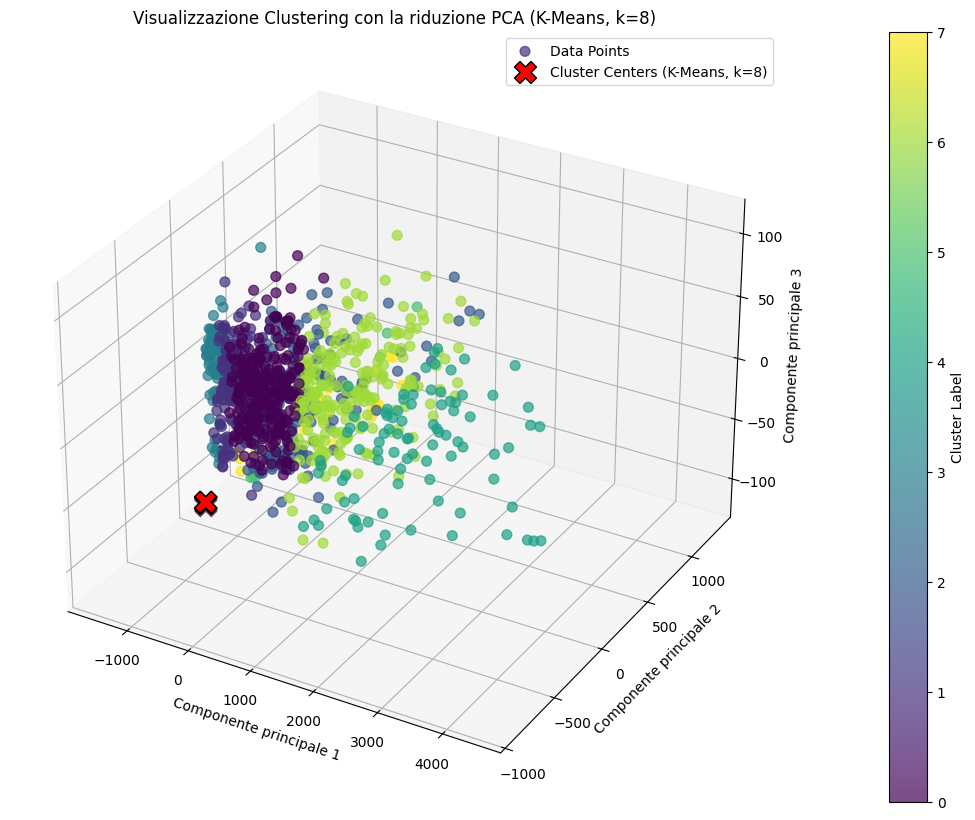

In [21]:
original_data = df.to_numpy() # (samples x features)

pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(original_data)

pca_transformed_centers_3d = pca_3d.transform(cluster_centers_original_space)
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

scatter_data = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                          c=crisp_labels_for_chosen_k, cmap='viridis', s=50, alpha=0.7, label='Data Points')

ax.scatter(pca_transformed_centers_3d[:, 0], pca_transformed_centers_3d[:, 1], pca_transformed_centers_3d[:, 2],
           c='red', s=250, marker='X', edgecolors='black', depthshade=True, label=f'Cluster Centers (K-Means, k={chosen_k})')

ax.set_title(f'Visualizzazione Clustering con la riduzione PCA (K-Means, k={chosen_k})')
ax.set_xlabel('Componente principale 1')
ax.set_ylabel('Componente principale 2')
ax.set_zlabel('Componente principale 3')

cbar = fig.colorbar(scatter_data, ax=ax, pad=0.1)
cbar.set_label('Cluster Label')

ax.legend()
plt.show()


--- Valutazione Performance Clustering (K-Means, k=8) ---
  Adjusted Rand Index (ARI):      0.1391
  Normalized Mutual Info (NMI):   0.2806
  Homogeneity:                    0.2759
  Completeness:                   0.2854
  V-measure:                      0.2806


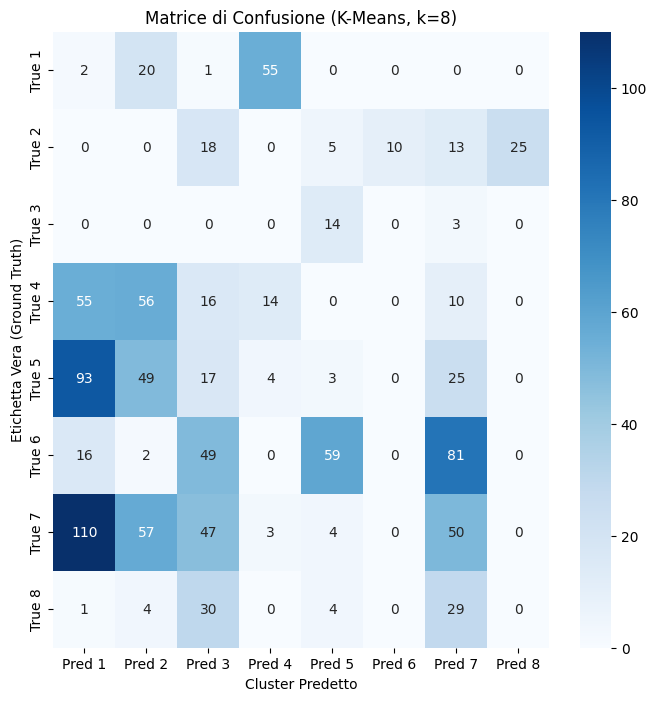

In [22]:
predicted_labels = crisp_labels_for_chosen_k

ari = adjusted_rand_score(true_labels, predicted_labels)
nmi = normalized_mutual_info_score(true_labels, predicted_labels)
homogeneity = homogeneity_score(true_labels, predicted_labels)
completeness = completeness_score(true_labels, predicted_labels)
v_measure = v_measure_score(true_labels, predicted_labels)

print(f"\n--- Valutazione Performance Clustering (K-Means, k={chosen_k}) ---")
print(f"  Adjusted Rand Index (ARI):      {ari:.4f}")
print(f"  Normalized Mutual Info (NMI):   {nmi:.4f}")
print(f"  Homogeneity:                    {homogeneity:.4f}")
print(f"  Completeness:                   {completeness:.4f}")
print(f"  V-measure:                      {v_measure:.4f}")

labels_for_plot_true = sorted(np.unique(true_labels))
labels_for_plot_pred = sorted(np.unique(predicted_labels))

expected_labels_indices = range(chosen_k)

cm = confusion_matrix(true_labels, predicted_labels, labels=expected_labels_indices)

plt.figure(figsize=(max(8, chosen_k), max(6, chosen_k)))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f'Pred {i+1}' for i in expected_labels_indices],
            yticklabels=[f'True {i+1}' for i in expected_labels_indices])
plt.xlabel("Cluster Predetto")
plt.ylabel("Etichetta Vera (Ground Truth)")
plt.title(f"Matrice di Confusione (K-Means, k={chosen_k})")
plt.show()

# Supervised Learning

Per quanto riguarda la parte supervisionata utilizzerò un modello di Logistic Regression multi-classe

In [23]:
df['true_labels'] = true_labels
df

,contrast,correlation,energy,homogeneity,ASM,dissimilarity,entropy,mean,std,variance,true_labels
0,544.768538,0.164024,0.020326,0.057026,0.000413,17.843220,7.997028,143.234375,18.050699,325.827748,0
1,197.159163,0.177359,0.032063,0.100065,0.001028,10.411811,7.188701,152.632813,10.946826,119.832996,0
2,102.146186,0.431943,0.035535,0.116129,0.001263,7.942267,6.980690,137.713189,9.482008,89.908470,0
3,815.514301,0.497055,0.016059,0.046025,0.000258,22.314089,8.414303,157.313030,28.473477,810.738877,0
4,387.655191,0.082963,0.024333,0.073753,0.000592,14.957627,7.685513,137.418432,14.538321,211.362785,0
...,...,...,...,...,...,...,...,...,...,...,...
1049,491.407839,0.618481,0.017489,0.057255,0.000306,17.510064,8.268916,105.647511,25.377462,644.015582,7
1050,633.080773,0.529442,0.016660,0.048319,0.000278,19.966367,8.334621,114.436573,25.936290,672.691157,7
1051,454.685911,0.701969,0.016817,0.055190,0.000283,16.983581,8.321434,89.413930,27.619118,762.815685,7
1052,412.023305,0.559700,0.018616,0.061413,0.000347,16.173729,8.152220,115.971928,21.630755,467.889572,7


Ora che abbiamo il dataframe contenente le features e le etichette di ground truth, possiamo procedere con la sua visualizzazione.

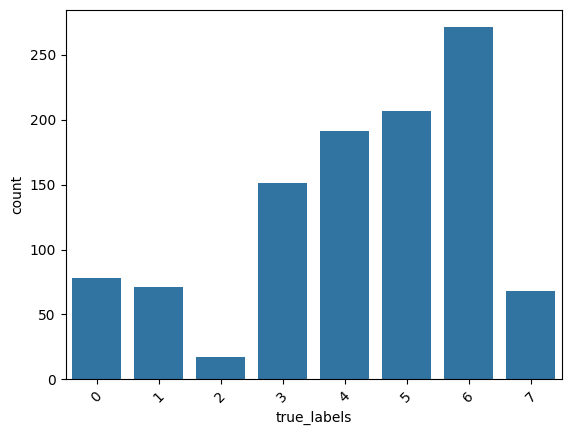

In [24]:
sns.countplot(x='true_labels', data=df)
plt.xticks(rotation=45)
plt.show()

In [25]:
features = ['contrast', 'homogeneity', 'energy', 'correlation', 'ASM', 'dissimilarity', 'entropy', 'mean', 'std', 'variance']

X_train, X_test, y_train, y_test = train_test_split(df[features], df['true_labels'], test_size=0.2, random_state=42, shuffle=True)

we can’t forget to scale our data. This is important because it help us to balance the impact of all variables on the distance calculation and can help to improve the performance of the algorithm

In [26]:
st_x = StandardScaler()
X_train = st_x.fit_transform(X_train)
X_test = st_x.transform(X_test)

In [27]:
def logistic_model(C, solver_):
    logistic_regression_model = LogisticRegression(random_state=42, solver=solver_, n_jobs=1, C=C, max_iter=5000)
    return logistic_regression_model

Text(0.5, 1.0, 'Beans Accuracy')

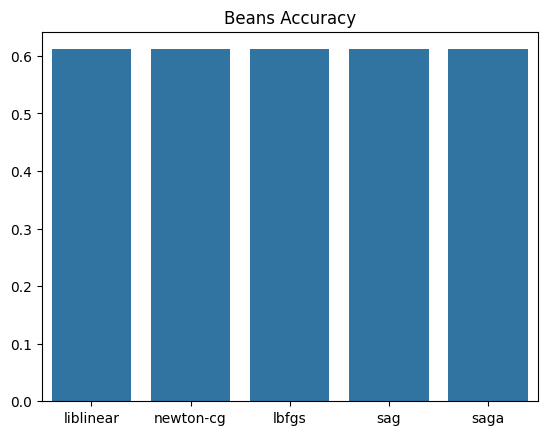

In [28]:
solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
scores = []
params = []

for i in solver_list:
        try:
            model = logistic_model(10, i)
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            params.append(i)
            accuracy = accuracy_score(y_test, predictions)
            scores.append(accuracy)
        except:
            print(f"Solver {i} ha generato un errore/warning: {e}")


sns.barplot(x=params, y=scores).set_title('Beans Accuracy')


In [29]:
print(f"Numero di classi uniche in y_train: {len(np.unique(y_train))}")
print(f"Classi uniche: {np.unique(y_train)}")

print("Scores ottenuti:")
for solver_name, score_val in zip(params, scores): # Assumendo che params e scores siano le tue liste
    print(f"  Solver: {solver_name}, Accuracy: {score_val:.6f}") # Stampa con più decimali

Numero di classi uniche in y_train: 8
Classi uniche: [0 1 2 3 4 5 6 7]
Scores ottenuti:
  Solver: liblinear, Accuracy: 0.611374
  Solver: newton-cg, Accuracy: 0.611374
  Solver: lbfgs, Accuracy: 0.611374
  Solver: sag, Accuracy: 0.611374
  Solver: saga, Accuracy: 0.611374


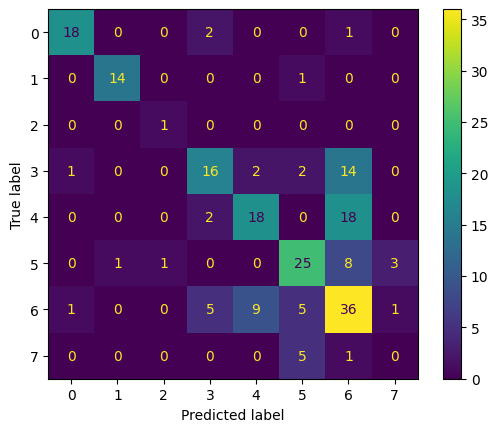

In [30]:
model = logistic_model(1, 'newton-cg')
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        21
           1       0.93      0.93      0.93        15
           2       0.50      1.00      0.67         1
           3       0.64      0.46      0.53        35
           4       0.62      0.47      0.54        38
           5       0.66      0.66      0.66        38
           6       0.46      0.63      0.53        57
           7       0.00      0.00      0.00         6

    accuracy                           0.61       211
   macro avg       0.59      0.63      0.59       211
weighted avg       0.62      0.61      0.60       211


Il modello ha 8 set di coefficienti (uno per classe vs resto).
Mostrando l'importanza per la prima classe (o la magnitudine assoluta media):

Feature Importance (Coefficients):
         Feature  Average Absolute Importance
7           mean                     1.286822
0       contrast                     0.861487
1    homo

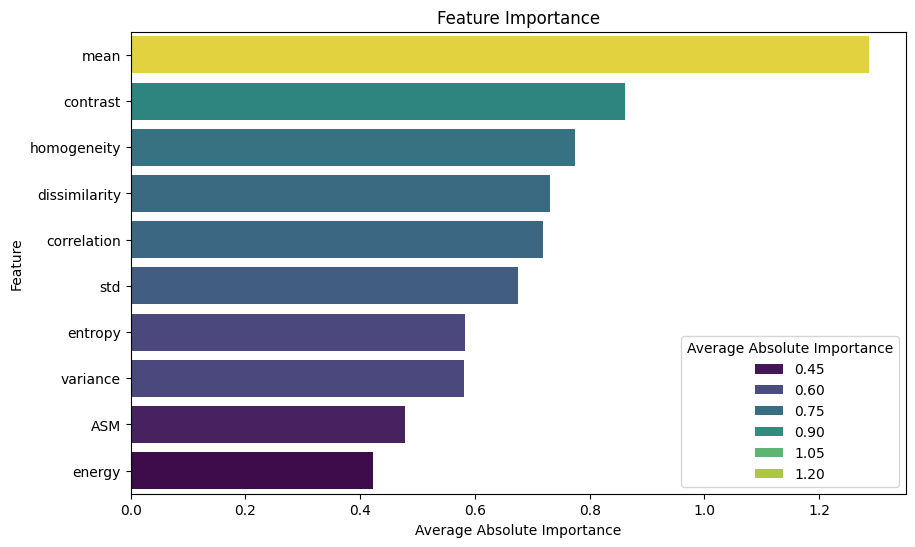

In [31]:
# Report di Classificazione
report = classification_report(y_test, predictions)
print("\nClassification Report:")
print(report)

# 3. Importanza delle Feature (Coefficienti del Modello)
if hasattr(model, 'coef_'):
    coefficients = model.coef_
    if coefficients.shape[0] == 1: 
        feature_importance = pd.DataFrame({'Feature': features, 'Importance': coefficients[0]})
        feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    else: 
        print(f"\nIl modello ha {coefficients.shape[0]} set di coefficienti (uno per classe vs resto).")
        print("Mostrando l'importanza per la prima classe (o la magnitudine assoluta media):")
        
        avg_abs_coeffs = np.mean(np.abs(coefficients), axis=0)
        feature_importance = pd.DataFrame({'Feature': features, 'Average Absolute Importance': avg_abs_coeffs})
        feature_importance = feature_importance.sort_values(by='Average Absolute Importance', ascending=False)

    print("\nFeature Importance (Coefficients):")
    print(feature_importance)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance' if 'Importance' in feature_importance.columns else 'Average Absolute Importance', y='Feature', data=feature_importance, palette='viridis', hue='Importance' if 'Importance' in feature_importance.columns else 'Average Absolute Importance')
    plt.title('Feature Importance')
    plt.show()
else:
    print("\nIl modello selezionato potrebbe non avere l'attributo 'coef_'.")


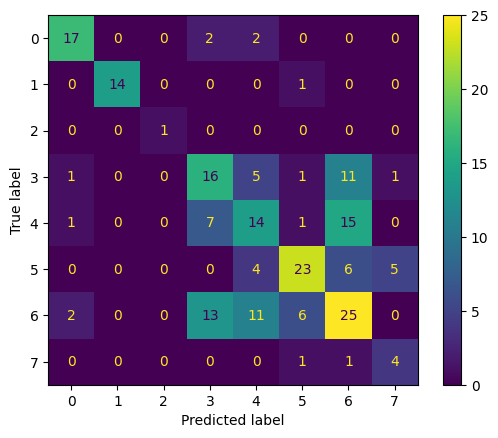

In [32]:
from sklearn import tree

model = tree.DecisionTreeClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()


## Fonti
- https://github.com/sbianco78/UnsupervisedPlanktonLearning
- Texture Feature Extraction Methods A Survey: https://hal.science/hal-02126655v1/file/Texture_Feature_Extraction_Methods_A_Survey.pdf
- Silhouette Score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
- Fuzzy C-Means: https://scikit-fuzzy.readthedocs.io/en/stable/api/generated/fuzzy_cmeans.html
- PCA: https://www.ibm.com/it-it/think/topics/principal-component-analysis
- Logistic Regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- Logistic Regression: https://danhergir.medium.com/implementing-multi-class-logistic-regression-with-scikit-learn-53d919b72c13